In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")
marks = pd.read_csv('train_ship_segmentations_v2.csv') # Markers for ships
images = os.listdir('train') # Images for training
os.chdir("train")

Using TensorFlow backend.


In [2]:
def mask_part(pic):
    '''
    Function that encodes mask for single ship from .csv entry into numpy matrix
    '''
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1+int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key):
    '''
    Function that checks if there is a ship in image
    '''
    df = marks[marks['ImageId'] == key].iloc[:,1]
    if len(df) == 1 and type(df.iloc[0]) != str and np.isnan(df.iloc[0]):
        return True
    else:
        return False
    
def masks_all(key):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = marks[marks['ImageId'] == key].iloc[:,1]
    masks= np.zeros((768,768,1))
    if is_empty(key):
        return masks
    else:
        for i in range(len(df)):
            masks += mask_part(df.iloc[i])
        return np.transpose(masks, (1,0,2))

Randomly chosen images with corresponding masks


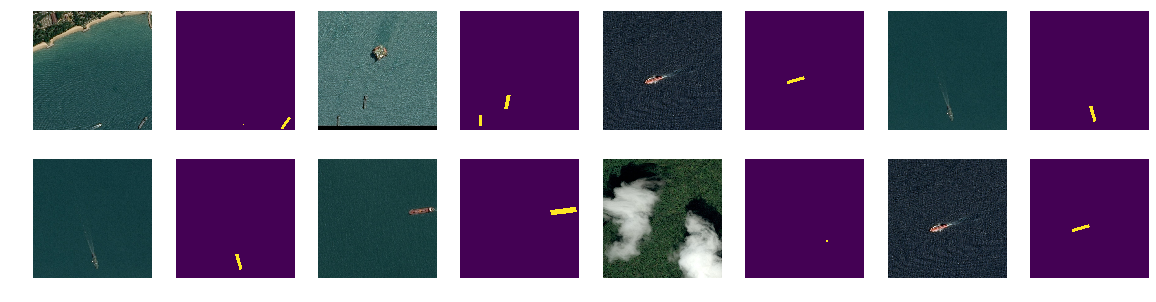

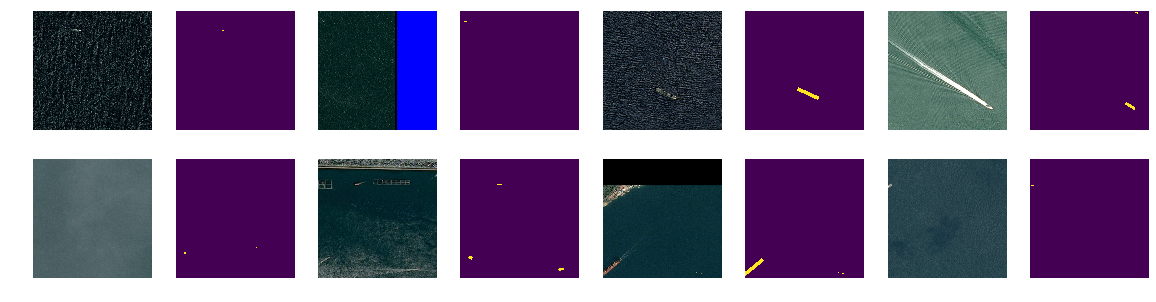

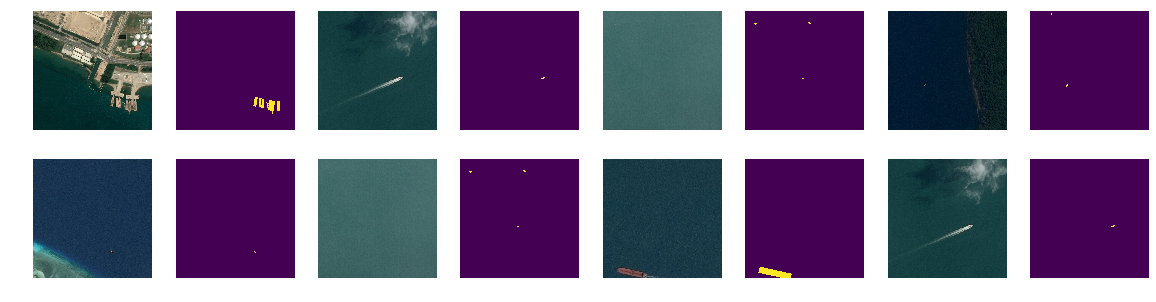

In [3]:
def draw(lista):
    l = int(len(lista)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(plt.imread(lista[i]))
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        plt.imshow(masks_all(lista[i])[:,:,0])
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()
print('Randomly chosen images with corresponding masks')
draw(np.random.choice([i for i in images[:200] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in images[200:400] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in images[400:600] if not is_empty(i)], size = 8))

# Data Augmentation

In [4]:
def transform(X, Y):
    '''
    Function for augmenting images. 
    It takes original image and corresponding mask and performs the
    same flipping and rotation transforamtions on both in order to 
    perserve the overlapping of ships and their masks
    '''
# add noise:
    x = np.copy(X)
    y = np.copy(Y)
    x[:,:,0] = x[:,:,0] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,1] = x[:,:,1] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,2] = x[:,:,2] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    # Adding Gaussian noise on each rgb channel; this way we will NEVER get two completely same images.
    # Note that this transformation is not performed on Y 
    x[np.where(x<0)] = 0
    x[np.where(x>1)] = 1
# axes swap:
    if np.random.rand()<0.5: # 0.5 chances for this transformation to occur (same for two below)
        x = np.swapaxes(x, 0,1)
        y = np.swapaxes(y, 0,1)
# vertical flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 0)
        y = np.flip(y, 0)
# horizontal flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 1)
        y = np.flip(y, 1)
    return x, y

In [5]:
def plot_transformed(file):
    '''
    Plots specified Original image and five augmentations
    (five images created transforming original with function 'transform()')
    '''
    X, Y = plt.imread(file), masks_all(file)
    plt.figure(figsize = (19,8))
    plt.subplot(253, title ='Original Image')
    X, Y = plt.imread(file)/255, masks_all(file)
    plt.imshow(X)
    plt.axis('off')
    plt.subplot(256, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(257, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(258, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(259, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(2,5,10, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.suptitle(file,x=0.3, y=0.7, verticalalignment ='top', fontsize = 22)
    plt.show()

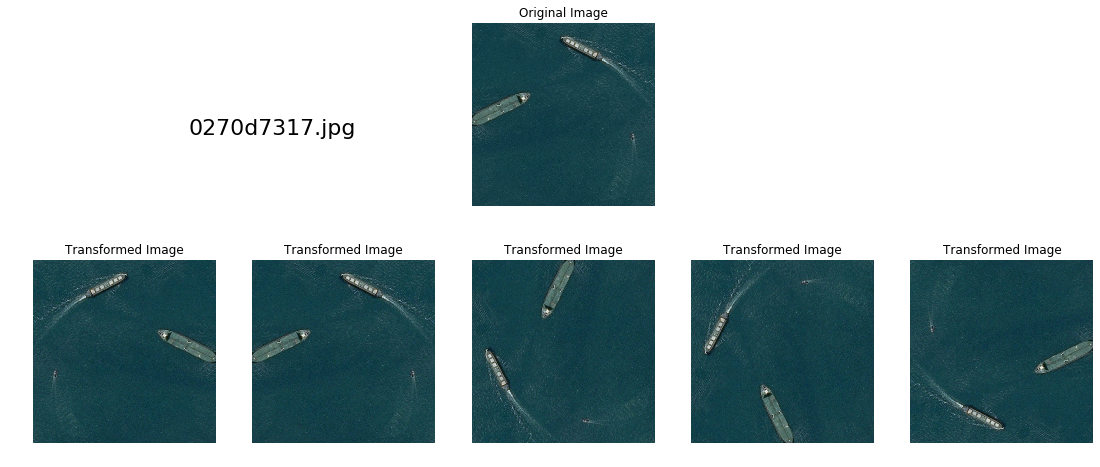

In [6]:
plot_transformed('0270d7317.jpg')

In [7]:
def make_batch(files, batch_size):
    '''
    Creates batches of images and masks in order to feed them to NN
    '''
    X = np.zeros((batch_size, 768, 768, 3))
    Y = np.zeros((batch_size, 768, 768, 1)) # I add 1 here to get 4D batch
    for i in range(batch_size):
        ship = np.random.choice(files)
        X[i] = (io.imread(ship))/255.0 # Original images are in 0-255 range, I want it in 0-1
        Y[i]= masks_all(ship)
    return X, Y

Finally, it is time to create Generator function combining two functions abowe. Images in batch are chosen at random so we can have one image occuring multiple times even in a single batch, but on each image in batch 'transform()' function is invoked fighting this problem.

In [8]:
def Generator(files, batch_size):
    '''
    Generates batches of images and corresponding masks
    '''
    while True:
        X, Y = make_batch(files, batch_size)
        for i in range(batch_size):
            X[i], Y[i] = transform(X[i], Y[i])
        yield X, Y

# Metrics and Loss Function

Keras package has a lot of built-in metrics, but default metrics are not always good choice. In this problem we need to make our own function for measuring quality of model. Metric I'll be using is called Intersection over Union. It is nicely presented at the figure below, where B1 would present ground truth mask of a ship and B2 is predicted mask. When this mattching is peerfect, metric value is 1 and the lower predicting precison is, the lower is this value (down to zero).

Below are implementations of IoU, which calculates this ratio for masks, and back_IoU, that does the same thing only now consiering background insted of masks. For metrics in model you can use both of these or only the first one (I wouldn't advise only the second one) .

But, when training NN, the loss function is the one that really matters. Simple way to create loss function is to take negative value of IoU metric. In this way we obtain function that decreases when our prediction is improving and increases otherwise.

In [9]:
# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)
# Intersection over Union for Background
def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)
# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)

# Models

In [4]:
import tensorflow as tf

# Weight initialization function
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return (tf.Variable(init_random_dist))

# Bias initialization function
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

# 2d convolution function which is already performed by tf
def conv2d(x, W):
    # x => input tensor ==> [batch, H, W, Channels]
    # W => kernel => [filter height, filter width, # of channels in, # channels out]
    return tf.nn.conv2d(x, W, strides=[1,1,1,1],padding="SAME")
# padding with SAME adds zeros to the end
# Strides is how you want to move in the whole thing [batch, height, width, channel]

# Pooling function in this case max pooling which gets the max value and is a 2x2 kernel
def max_pool_2by2(x):
    # x=> input => [batch, h, w, c]
    return (tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME"))
# Ksize = size of the window which makces the pooling [batch, h, w, c] => here 1 is like pasing all 2 is reducing
    # We only want to reduce the height and width of the image, that is why we use 
    # [1 in batch, 2 in height, 2 in width, 1 in channel]
#  Stride here is [1, 2, 2, 1] because we want to shorten the image so we jump 2 by 2 pixels in the image

# convolutional layer function
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]]) 
    # we take the third one because that is the number of channels we are using
    # is not really intuitive but the channels is like the number of features
    # first is going to be 1 then more
    return (tf.nn.relu(conv2d(input_x, W)+b))

# normal layaer (fully connected layer)
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1]) 
    # we use the index one beacause 0 is the batch size and 1 is the number of nodes
    W = init_weights([input_size, size])
    b = init_bias([size])
    return (tf.matmul(input_layer, W)+b)
# simple weighted sum

def deconv2d(x, W, stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID', name="conv2d_transpose")

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")

In [ ]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features['x'], [-1, 768, 768, 3])
    
    # Conv1
    c1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 8,
        kernel_size = [3, 3],
        padding='same',
        activation=tf.nn.relu
    )
    # Pool1
    p1 = tf.layers.max_pooling2d(
        inputs = c1,
        pool_size=[2, 2],
        strides=2
    )
    # Conv2
    c2 = tf.layers.conv2d(
        inputs = p1,
        filters = 16,
        kernel_size = [3, 3],
        padding = 'same',
        activation = tf.nn.relu
    )
    # Pool2
    p2 = tf.layers.max_pooling2d(
        inputs = c2,
        pool_size=[2,2],
        strides=2
    )
    # Conv3
    c3 = tf.layers.conv2d(
        inputs=p2,
        filters=32,
        kernel_size = [3, 3],
        padding = 'same',
        activation = tf.nn.relu
    )
    # Pool3
    p3 = tf.layers.max_pooling2d(
        inputs = c3,
        pool_size = [2,2],
        strides=2
    )
    # Conv4
    c4 = tf.layers.conv2d(
        inputs = p3,
        filters = 64,
        kernel_size = [3,3],
        padding = 'same',
        activation = tf.nn.relu
    )
    
    concatatenate

In [10]:
inputs = Input((768, 768, 3))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c5 = Conv2D(32, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(16, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(16, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(8, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(8, (3, 3), activation='relu', padding='same') (c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss= IoU_loss, metrics=[IoU, back_IoU])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 768, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 384, 384, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

Setting batch_size = 200 and steps_per_epoch = 500 gives 200*500 = 100.000 images to train on. That is around the same size of available training set, so you shouldn't go under this, but considering our generator function, probably a lot of images won't be taken in consideration, so I encourage you to increase both, batch size and steps, freely.

Here, I will put absurdly small parameters just in order to check if everithing is working fine.

In [11]:
#results = model.fit_generator(Generator(images, batch_size = 200), steps_per_epoch = 500, epochs = 30)
results = model.fit_generator(Generator(images, batch_size = 20), steps_per_epoch = 50, epochs = 1)

Epoch 1/1
50/50 [==============================] - 1373s 27s/step - loss: 0.9986 - IoU: 0.0014 - back_IoU: 0.4140
